In [1]:
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *
from PreFRBLE.sample import *

from IPython.display import display, Latex

## Redshift distribution and IGM baryon content
Here we perform a joint inference of the host redshift distribution of FRBs and the baryon content in the IGM, $f_{\rm IGM}$, which are both not well known.
Together, the two determine the shape of the observed distribution of DM, which is dominated by the IGM.
Inference using unlocalized FRBs thus has to consider both to solve this degenerate Problem.
Here we show how to use assumed FRB redshift distributions (see _notebooks/model/Gardenier20.ipynb_) and estimates for contributions to DM from all regions along the LoS in order to infer both, the intrinsic redshift distribution as well as the IGM baryon content.

In [23]:
### benchmark scenario
scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
    'N_inter' : True
}


f_IGMs = np.arange(0.300,0.901, 0.100)  
f_IGMs_range = f_IGMs-0.05
f_IGMs_range = np.append( f_IGMs_range, f_IGMs[-1]+0.05)



In [3]:
def LikelihoodObservedDM( scenario={}, telescope='Parkes', population='SMD', FRBs=None, DMs=None, use_localized=True, plot=False, plot_FRBs=False, ax=None, label=None, title=None ):
    """ 
    returns likelihood of values of DM observed by telescope for the case of scenario and population
    
    Parameters
    ----------
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
    
    Returns
    -------
    likelihoods : array-like
        1D array with likelihoods of individual DM observed by telescope  
    """
    P_DM, DM, dev_DM = GetLikelihood_Telescope( measure='DM', telescope=telescope, population=population, dev=True, **scenario )
        
    if DMs is None:
        ## read observed values of extragalactic DM
        if FRBs is None:
            FRBs = GetFRBcat( telescopes=[telescope] )
        DMs = FRBs['DM']-FRBs['DM_gal']
    
    if plot:
        if ax is None:
            fig, ax = plt.subplots()
        if title is None:
            title = "%s with %s" % (population, labels[telescope])
        ax.set_title( title, fontsize=16 )
        ax.tick_params(axis='both', which='major', labelsize=16)

        PlotLikelihood( P=P_DM, x=DM, dev=dev_DM, measure='DM', ax=ax, label=label )

        if plot_FRBs:
            P_, x_ = Histogram( data=DMs, bins=10, log=True, density=True, range=(1e1,1e4) )
            dev_obs = LikelihoodDeviation( P=P_, x=x_, N=len(DMs) )
            PlotLikelihood( P=P_, x=x_, dev=dev_obs, measure='DM', ax=ax, label="observed", linestyle='-.', color='black' )
    
    ## compute likelihood of observation
    likelihoods, deviations = Likelihoods( measurements=DMs, P=P_DM, x=DM, dev=dev_DM )
    
    ## for FRBs with localized host, use likelihood for DM from that redshift, P(DM|z_host), instead
    if use_localized:
        localized, = np.where( FRBs['host_redshift']>0 )
        ## selection effects of telescope don't change ratio of prior likelihood of z between populations, but too low number of FRBs to reconstruct population can result in numerical errors. Thus use the cosmic population instead, which has better statistics.
        ##P_z, z = GetLikelihood_Redshift( population=population, telescope='None' )
        ## THIS IS BULLSHIT, since the maximum observable value of redshift cuts the prior, these values are renormalized differently. This has to be taken into account, e. g. by cutting the cosmic population at maximum redshift
        ##P_z, z = LikelihoodMeasureable( P=P_z, x=z, min=0, max=0.75 )
        ## HOWEVER, this strongly depends on the choice of maximum redshift ...
        
        for loc in localized:
            z_host = np.round(FRBs[loc]['host_redshift'],1)
            if z_host == 0:  ## fails for host at too low distance, right now only consider far rays to z >= 0.1
                continue
            
            P_z, z, dev_z = GetLikelihood_Redshift( population=population, telescope=telescope, dev=True )
            P_DM, DM, dev_DM = GetLikelihood_Full( measure='DM', redshift=z_host, dev=True, **scenario )
            ## likelihood for host redshift in population 
            prior, dev_prior = Likelihoods( measurements=[z_host], P=P_z, x=z, dev=dev_z ) ##**( 1 - (telescope in ['ASKAP']) )  ## ignore redhift prior for these telescope, since they are not informative for population
            ## multiply by likelihood for DM at host redshift
            l, d = Likelihoods( measurements=[DMs[loc]], P=P_DM, x=DM, dev=dev_DM )
            likelihoods[loc] = (l*prior)[0]
            deviations[loc] = np.sqrt( d[0]**2 + dev_prior[0]**2 )
        if plot and False:
            y_DMs = 0.75-0.5*np.random.rand( len(localized) )
            ax.plot( DMs[localized], y_DMs, marker='x', linestyle=' ' )
    return likelihoods, deviations

def LikelihoodBaryonContent( f_IGMs=f_IGMs, scenario={}, telescope='Parkes', population='SMD', FRBs=None, DMs=None ):
    """ 
    returns likelihood of values of f_IGM in DM_EG = f_IGM*z*1000 pc cm^-3, that present different IGM baryon contents.
    Likelihoods are quantified by how well DM observed by telescope agree with predictions for the case of scenario and population
    
    Parameters
    ----------
    f_IGMs : array-like
        possible values of f_IGM
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
        
    Returns
    -------
    likelihoods : array-like
        2D array with likelihoods of values of f_IGM according to individual DM observed by telescope
    """
    
    if FRBs is None:
        FRBs = GetFRBcat( telescopes=[telescope] )
    
    likelihoods, deviations = [], []
    for f_IGM in f_IGMs:
        tmp = scenario.copy()
        tmp['IGM'] = ['primordial_C%.0f' % (f_IGM*1000)]
        l, d =  LikelihoodObservedDM( scenario=tmp, telescope=telescope, population=population, FRBs=FRBs, DMs=DMs )
        likelihoods.append( l )
        deviations.append( d )
    likelihoods = np.array( likelihoods )
    deviations = np.array( deviations )
    return likelihoods, deviations
    
    

def BayesBaryonContentPopulationTelescope( scenario={}, FRBs=None, telescope='Parkes', f_IGMs=f_IGMs, populations=populations, plot=False, DMs=None, ax=None):
    """ 
    returns joint likelihood of FRB populations and values of f_IGM in DM_EG = f_IGM*z*1000 pc cm^-3, that present different IGM baryon contents.
    Likelihoods are quantified by how well DM observed by telescope agree with predictions for the case of scenario and population
    
    Parameters
    ----------
    f_IGMs : array-like
        possible values of f_IGM
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
        
    Returns
    -------
    likelihoods : array-like
        2D array with likelihoods of tuples of FRB populations and values of f_IGM according to individual DM observed by telescope
    """
    
    if FRBs is None:
        FRBs = GetFRBcat( telescopes=[telescope] )        

    ## for each population, obtain the likelihoods of values of f_IGM for individual DM observed by telescope
    likelihoods, deviations = [], []
    for population in populations:
        l, d = LikelihoodBaryonContent(  f_IGMs=f_IGMs, FRBs=FRBs, DMs=DMs, population=population, telescope=telescope, scenario=scenario )
        likelihoods.append( l )
        deviations.append( d )
    likelihoods = np.array( likelihoods )  # 3D array (N_pop, N_f_IGMs, N_FRBs)
    deviations = np.array( deviations )
    
    ## obtain bayes factors by renormalizing to one tuple of f_IGM and redhift distribution
    P2 = likelihoods[0,0] * np.ones( likelihoods.shape )
    dev2 = deviations[0,0] * np.ones( likelihoods.shape )
    bayes, dev_bayes = BayesFactor( P1=likelihoods, P2=P2, dev1=deviations, dev2=dev2, axis=2)
    
    localized, = np.where(FRBs['host_redshift'] > 0 )
    
    if plot:
        allticks = False
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_title( "%s, N=%i" % ( telescope, len(FRBs) if DMs is None else len(DMs) ), fontdict={'size':22 }  )
            ax.tick_params(axis='both', which='major', labelsize=16)
            ax.set_ylim(1e-8,1.5)
            allticks = True
        PlotBayes2D(  bayes=bayes, dev=dev_bayes, x=f_IGMs, y=populations, xlabel=r"$f_{\rm IGM}$", ylabel='population', graphs=True, ax=ax )
        if allticks:
            AllSidesTicks(ax=ax)
    return bayes, dev_bayes
    
    
def BayesBaryonContentPopulation( scenario={}, telescopes=telescopes, f_IGMs=f_IGMs, populations=populations, FRBs=None, plot=False, plot_telescopes=False):
    """ 
    returns joint likelihood of FRB populations and values of f_IGM in DM_EG = f_IGM*z*1000 pc cm^-3, that present different IGM baryon contents.
    Likelihoods are quantified by how well DM observed by any of telescopes agree with predictions for the case of scenario and population
    
    Parameters
    ----------
    f_IGMs : array-like
        possible values of f_IGM
    pi_c : float or array_like, same size as f_IGMs
        prior likelihoods of values of f_IGM
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
        
    Returns
    -------
    bayes : array-like
        2D array with Bayes factors of tuples of FRB populations and values of f_IGM according to individual DM observed by any of telescopes
    """
    bayes, dev_bayes = [], []
    
    for telescope in telescopes:
        if FRBs is not None:
            frbs = FRBs[FRBs['tele'] == telescopes_FRBcat[telescope]]
        else:
            frbs = None
        b, d = BayesBaryonContentPopulationTelescope( scenario=scenario, telescope=telescope, f_IGMs=f_IGMs, populations=populations, plot=plot_telescopes, FRBs=frbs )
        bayes.append( b )
        dev_bayes.append( d )
    bayes = np.prod( np.array(bayes), axis=0 )
    dev_bayes = np.sqrt( np.sum( np.array(dev_bayes)**2, axis=0 ) )
    
    if plot:
        PlotBayes2D(  bayes=bayes, dev=dev_bayes, x=f_IGMs, y=populations, xlabel=r"$f_{\rm IGM}$", ylabel='population', graphs=True )

    return bayes, dev_bayes
            
    

### Expectation vs. Observation
Using the assumed distribution of host redshifts of observed FRBs $\pi(z)$ together with the expected likelihood of DM from different redshift $L(\text{DM}|z,f_{\rm IGM})$ according to chosen $f_{\rm IGM}$, we obtain the distribution of DM expected to be observed by terrestrial telescopes via prior weighed integral
$$
L(DM) = \int L(DM|z,f_{\rm IGM}) ~\pi(z) ~\text{d}z .
$$
Here we plot the distribution of extragalactic DM$_{\rm EG}$ as measured at different observatories (dash-dotted) together with the expected distribution assuming the benchmark scenario with two extreme values of $f_{\rm IGM}$ and three different redshift distributions.

{'IGM': ['primordial_C300'], 'N_inter': True, 'Inter': ['Rodrigues18'], 'Local': ['Piro18/wind'], 'Host': ['Rodrigues18']}


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5


{'IGM': ['primordial_C900'], 'N_inter': True, 'Inter': ['Rodrigues18'], 'Local': ['Piro18/wind'], 'Host': ['Rodrigues18']}


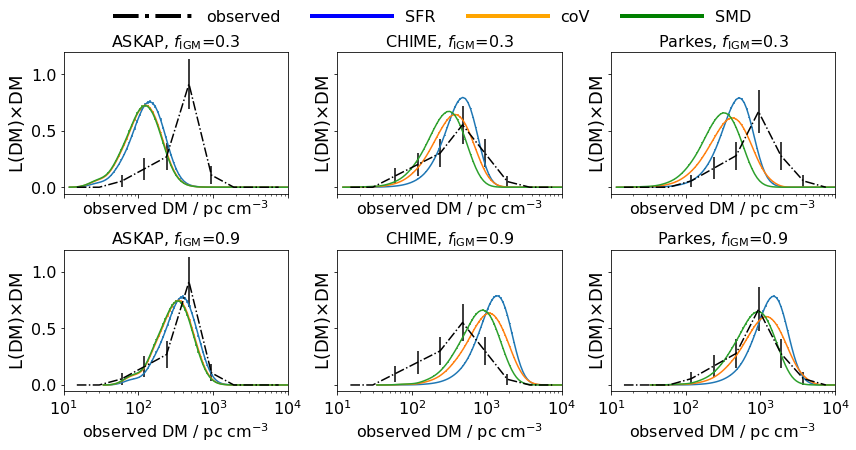

In [5]:
fig, axss = plt.subplots( 2, 3, figsize=(12,6), sharex=True, sharey=True)
for f_IGM, axs in zip( f_IGMs[np.array([0,-1])], axss ):
    tmp = scenario.copy()
    tmp['IGM'] = ['primordial_C%.0f' % (f_IGM*1000)]
    print(tmp)
    for telescope, ax in zip( telescopes, axs):
        ax.set_xlim(1e1,1e4)
        for population in populations:
            LikelihoodObservedDM( scenario=tmp, telescope=telescope, population=population, plot=True, ax=ax, plot_FRBs=population == populations[-1], label=population, title=r"%s, $f_{\rm IGM}$=%.1f" % (labels[telescope], f_IGM) )
        ax.set_yscale('linear')
        ax.tick_params(axis='both', which='major', labelsize=16)

from matplotlib.lines import Line2D
lines = [Line2D([0],[0], color='black', lw=4, ls='-.'),
         Line2D([0],[0], color='blue', lw=4),
         Line2D([0],[0], color='orange', lw=4),
         Line2D([0],[0], color='green', lw=4),
        ]

fig.legend( lines, np.append('observed', populations), fontsize=16, loc='lower center', bbox_to_anchor=(0.5, 0.97), ncol=4, borderaxespad=0, frameon=False,handlelength=5 )
fig.tight_layout()

### Bayes factor
The better the prediction matches the observed distribution of DM, the better is the model, i. e. the higher is the likelihood of observations to be reproduced by the model.
The Bayes factor $\mathcal{B} = \frac{L_1}{L_0}$ quantifies how much better (or worse) a model 1 explains the data than model 2.
For each individual measurement, we compute $\mathcal{B}$ as the likelihood for the investigated scenario, renormalized to the same refernece scenario for easy comparison. 
The highest value $\mathcal{B}_{\rm max}$ marks the most likely scenario.
By renormalizing to that value, interpretation of $\mathcal{B}$ is straightforward: a scenario with $\mathcal{B} < 10^{-2}$ is 100 times less likely to reproduce observations.
Since we assume uniform prior for all probed redshift distributions, $\mathcal{B}$ for constanf $f_{\rm IGM}$ also represents the ratio of posterior.

We start with investigation of the ASKAP sample, where we consider localized and unlocalized events individually.

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5


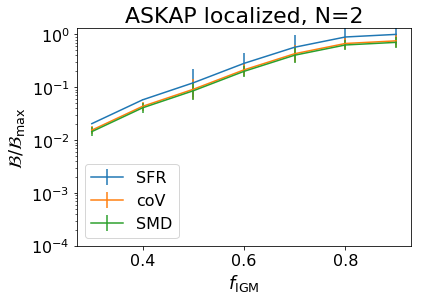

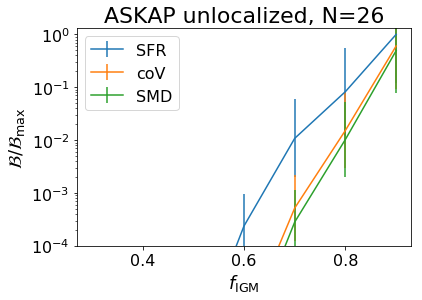

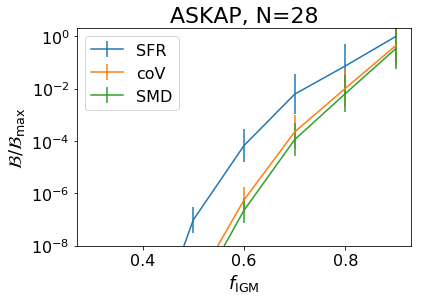

In [5]:

FRBs = GetFRBcat( telescopes=telescopes[:1])
localized = FRBs['host_redshift']>0

fig, ax = plt.subplots()
bayes_loc, dev_bayes_loc = BayesBaryonContentPopulationTelescope(  FRBs=FRBs[localized],  scenario=scenario, plot=True, telescope=telescopes[0], ax=ax ) 
ax.set_title( 'ASKAP localized, N=%i' % np.sum(localized) , fontdict={'size':22})
ax.set_ylim(1e-4,1.3)
AllSidesTicks(ax)
plt.show()

fig, ax = plt.subplots()
bayes_unloc, dev_bayes_unloc = BayesBaryonContentPopulationTelescope(  FRBs=FRBs[ np.logical_not(localized)],  scenario=scenario, plot=True, telescope=telescopes[0], ax=ax ) 
ax.set_title( 'ASKAP unlocalized, N=%i' % np.sum(np.logical_not(localized)) , fontdict={'size':22})
ax.set_ylim(1e-4,1.3)
AllSidesTicks(ax)
plt.show()


fig, ax = plt.subplots()
PlotBayes2D( bayes=bayes_loc*bayes_unloc, dev=np.sqrt( dev_bayes_loc**2 + dev_bayes_unloc**2 ), N_bayes=len(GetFRBcat(telescopes)), x=Cs, xlabel=r"$f_{\rm IGM}$", y=populations, graphs=True, ax=ax )
ax.set_title( 'ASKAP, N=%i' % len(FRBs) , fontdict={'size':22})
ax.set_ylim(1e-8,2)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()


Then we investigate the full sample of all three telescopes and combine their results, which is as simple as $\mathcal{B} = \prod\limits_i \mathcal{B}_i$, as has been done for the individual events of each telescope.

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5


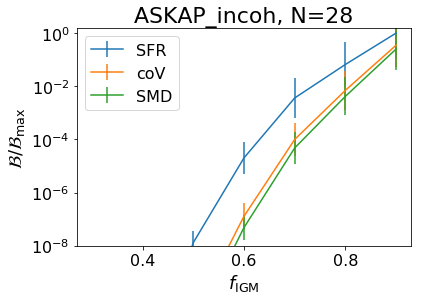

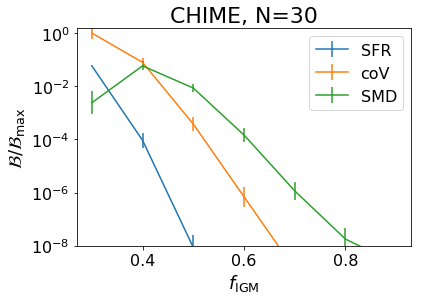

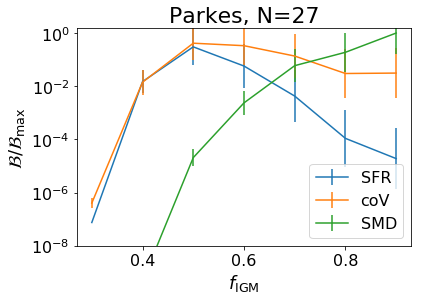

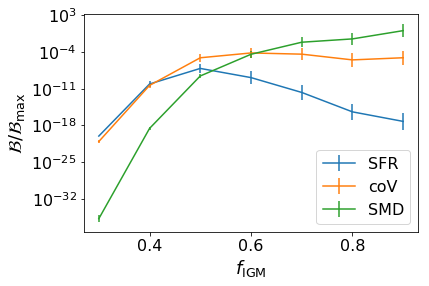

In [6]:
bayes, dev_bayes = BayesBaryonContentPopulation(  scenario=scenario, plot=True, plot_telescopes=True )#, telescopes=['ASKAP'] ) 

A nicer version of the last plot

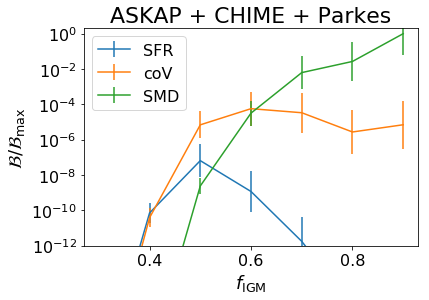

In [7]:
fig, ax = plt.subplots()

PlotBayes2D( bayes=bayes, dev=dev_bayes, x=Cs, xlabel=r"$f_{\rm IGM}$", y=populations, graphs=True, ax=ax)
ax.set_title( 'ASKAP + CHIME + Parkes', fontdict={'size':22})
ax.set_ylim(1e-12,2)
ax.tick_params(axis='both', which='major', labelsize=16)
#AllSidesTicks(ax)

However, these combined results, as the Posterior shown below, should be considered with caution, since the instruments deliver completely different results, when looked at individually.
While the high preference for high $f_{\rm IGM}$ definitely stems from ASKAP, the favouring of SMD is mostly provided by CHIME results, which absolutely dislikes such high values of $f_{\rm IGM}$.
This difference has to be explained on a theoretical level and factored into the predictions, in order to arrive at meaningful results.

### Posterior Likelihood
In order to arrive at the posterior likelihood of scenarios, according to Bayes Theorem, we have to factor in the prior likelihood of scenarios, which quantifies our believes based on previous observations and theoretical arguments.
We consider all populations to be of same likelihood, while simulations suggest a value of $f_{\rm IGM} = 0.8 - 0.9$. We thus quantify the prior of $f_{\rm IGM}$ with a gaussian, whose 1$\sigma$ interval covers these values.

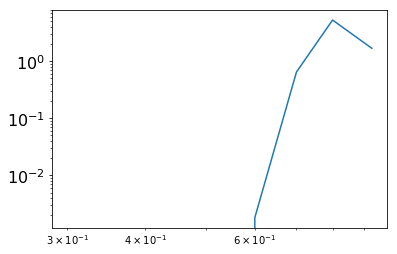

In [6]:
mu = 0.85
sigma = 0.05
N=10**6

f_IGMs_ =  np.random.normal( mu, sigma, N )
P_fIGM, fIGM = Histogram( data=f_IGMs_, bins=len(f_IGMs), range=f_IGMs_range[np.array([0,-1])], density=True )
PlotLikelihood( P=P_fIGM, x=f_IGMs_range)


def PosteriorBaryonContentPopulation( scenario={}, telescopes=telescopes, plot=False, prior=P_fIGM ):
    bayes = BayesBaryonContentPopulation(  scenario=scenario, plot=plot, telescopes=telescopes ) 
    return bayes * prior.reshape([1,len(prior)])


This is the assumed prior, now we multiply this by the likelihoods obtained above

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/plot.py:72: RuntimeWarning: divide by zero encountered in log10
  yerr = np.array([ b- 10.**( np.log10(b) - dev[ib]), 10.**(np.log10(b) + dev[ib]) - b ])


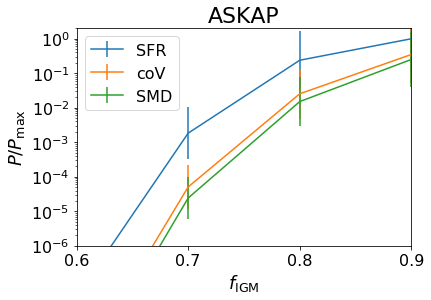

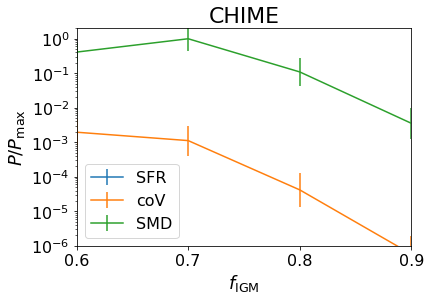

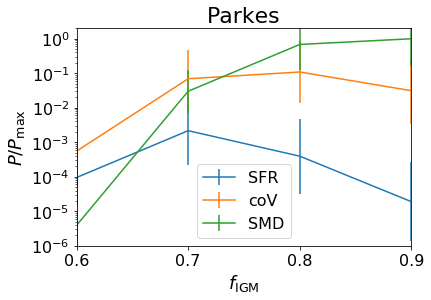

In [7]:
for telescope in telescopes:

    bayes, dev_bayes = BayesBaryonContentPopulation(  scenario=scenario, plot_telescopes=False, telescopes=[telescope] ) 
    posterior = bayes * P_fIGM.reshape([1,len(P_fIGM)])    
    
    fig, ax = plt.subplots()
    PlotBayes2D( bayes=posterior, dev=dev_bayes, x=f_IGMs, xlabel=r"$f_{\rm IGM}$", y=populations, graphs=True, ax=ax, posterior=True)
    ax.set_title( labels[telescope], fontdict={'size':22})
    ax.set_ylim(1e-6,2)
    ax.set_xlim(0.6,0.9)
#    AllSidesTicks(ax)


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/plot.py:72: RuntimeWarning: divide by zero encountered in log10
  yerr = np.array([ b- 10.**( np.log10(b) - dev[ib]), 10.**(np.log10(b) + dev[ib]) - b ])


(0.59, 0.91)

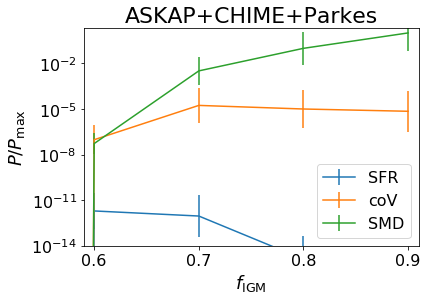

In [8]:
bayes, dev_bayes = BayesBaryonContentPopulation(  scenario=scenario, plot_telescopes=False, telescopes=telescopes ) 
posterior = bayes * P_fIGM.reshape([1,len(P_fIGM)])

fig, ax = plt.subplots()
PlotBayes2D( bayes=posterior, dev=dev_bayes, x=f_IGMs, xlabel=r"$f_{\rm IGM}$", y=populations, graphs=True, ax=ax, posterior=True)
ax.set_title( "ASKAP+CHIME+Parkes", fontdict={'size':22})
ax.set_ylim(1e-14,2)
ax.set_xlim(0.59,0.91)
#AllSidesTicks(ax)

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/plot.py:72: RuntimeWarning: divide by zero encountered in log10
  yerr = np.array([ b- 10.**( np.log10(b) - dev[ib]), 10.**(np.log10(b) + dev[ib]) - b ])


(0.6, 0.9)

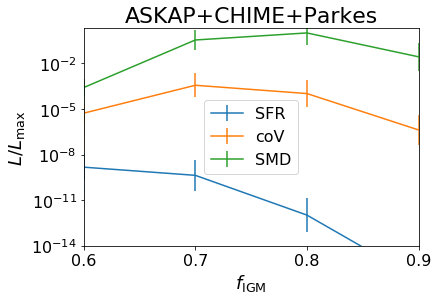

In [12]:
## here, only compute posterior form FRBs observed without RM, to be multiplied to results of IGMF inference

FRBs = GetFRBcat( telescopes=telescopes )
FRBs = FRBs[~(np.abs(FRBs['RM'])>0)]

bayes, dev_bayes = BayesBaryonContentPopulation(  scenario=scenario, plot_telescopes=False, telescopes=telescopes, FRBs=FRBs ) 
posterior = bayes * P_fIGM.reshape([1,len(P_fIGM)])

posterior.tofile( "posterior_fIGM.npy", sep=' ')
## read with
## posterior = np.genfromtxt("posterior_fIGM.npy").reshape(len(populations),len(f_IGMs))


fig, ax = plt.subplots()
PlotBayes2D( bayes=posterior, dev=dev_bayes, x=f_IGMs, xlabel=r"$f_{\rm IGM}$", y=populations, graphs=True, ax=ax, posterior=True)
ax.set_title( "ASKAP+CHIME+Parkes", fontdict={'size':22})
ax.set_ylim(1e-14,2)
ax.set_xlim(0.6,0.9)
#AllSidesTicks(ax)

### Localized FRBs
Here we consider the five localzed FRBs in order to estimate $f_{\rm IGM}$ without the need to assume a redhift distribution (cf. Li et al. 2020).

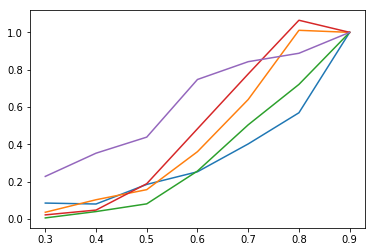

Norm 1.0


<IPython.core.display.Latex object>

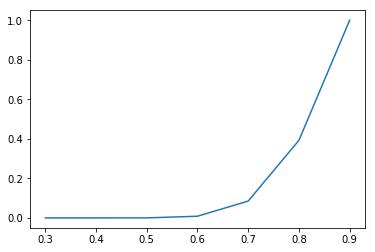

In [24]:
IDs = ['FRB121102','FRB180924','FRB190523','FRB181112','FRB180916']
zs = [0.19,0.32,0.66,0.47, 0.1] #0.03] too low redshift for current models
DMs = [340,290,659,457,84 ]

df = np.diff(f_IGMs_range)

P_F = []
for z, DM in zip(zs, DMs):
    P_f = []
    for f_IGM in f_IGMs:
        ## read corresponding P(DM|z,f)
        tmp = scenario.copy()
        tmp['IGM'] = ['primordial_C{:.0f}'.format(f_IGM*1000)]
        P, x = GetLikelihood_Full( measure='DM', redshift=np.round(z,1), dev=False,  **tmp )
        ## obtain P(DM_0|z_0,f)
        l, = Likelihoods( [DM], P, x )
        P_f.append(l)
    ## renormalize all P to f_0 -> Bayes(f)
    P_f = np.array(P_f)/P_f[-1]
    plt.plot( f_IGMs, P_f)
#    plt.show()
    P_F.append( P_f )
## Jackknife Bayes(f) for all FRBs
P_F = np.array(P_F)  ### shape(IDs,f_IGMs)
B_F = np.prod( P_F, axis=0)
#B_F, dev_F = BayesFactorTotal( P_F, axis=0 )
B_F /= B_F.max()

## plot B+dev as function of f
plt.show()
plt.errorbar( f_IGMs, B_F )

## read of estimate
### first, renormalize
B_F /= sum(B_F*df)
print( 'Norm', LikelihoodNorm( x=f_IGMs_range, P=B_F ) )
res, dev = Likelihood2Expectation( P=B_F, x=f_IGMs_range, log=False, sigma=3 )
display(Latex( r"$f_{{\rm IGM}} = {0:.2f}^{{+{2:.2f}}}_{{-{1:.2f}}} $".format( res, *dev.flat) ))
